## Learning Objectives

Today we learn the answer to these two questions:

* Why do complex models have higher variance?
* Why do complex models have higher generalization error?

The answer will be noise!

## It's about time

So we have hit the climax of the class. The bias variance trade off/approximation generalization trade off are the most important concepts in all of data science. But we did not just get here easily, we took a long road.

We talked about summary statistics and then used bootstrapping to apply them to populations that we cannot see. We then used this logic to show that we can learn arbitrary functions. We used bootstrapping to bound our error, and we showed that if we had a bigger hypothesis set the bound would be looser and if we had more data the bound would be tighter.

We saw that same concept phrased in two different ways. First we saw it expressed in the approximation generalization framework. We saw that more complex hypotheses could fit the training data perfectly, but their out of sample error/test error was often bigger than simpler hypotheses in low data regimes.

We then saw that concept phrased in the bias variance way. We know that more complex hypotheses can fit the true distribution better (that being said we will never have the true distribution aka infinite data). We also know that more complex hypothesis can vary more, as in they can often propose final hypotheses that are pretty different from their optimal one. We can then use this idea to estimate the out of sample error by adding the bias to the variance (adding the best hypothesis to the average amount you are off the best hypothesis). 

So parts of these explanations should be intuitively clear to you:

1. More complex hypotheses can have lower in sample/training error
2. More complex hypotheses will have a lower bias/error if they knew the true distribution

This is true because a more complex hypothesis can express everything that a simpler can. It's like a toolbox with more tools, just because you have add a screw driver does not mean that you forget to use your hammer. 

But there should be some questions that still linger:

* Why do complex models have higher variance?
* Why do complex models have higher generalization error?

Hopefully the next bits of explanation will help out this this.

## Noise

We have talked about noise before, but this time we are going to be going deeper into it. The noise we talked about last time was adding some randomness to a deterministic function, for example we can use this example below:

In [ ]:
%matplotlib inline
import numpy as np
import seaborn as sns
from numpy.polynomial.legendre import Legendre

second_order_intercepts = np.random.uniform(-1, 1, size=3)
L = Legendre(second_order_intercepts)

X = np.random.uniform(-1, 1, size=100)
y = L(X)

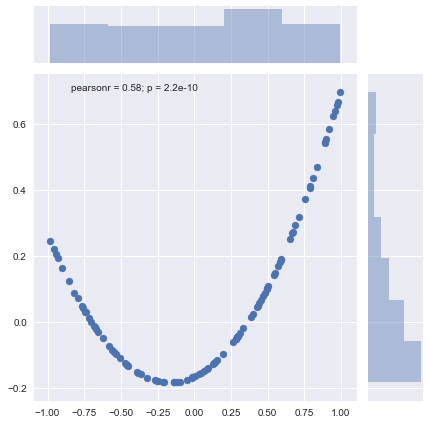

In [15]:
# without noise
sns.jointplot(X, y)

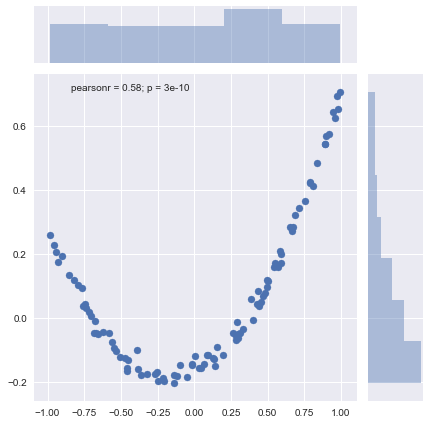

In [17]:
# with noise
y_noise = y + np.random.normal(scale=.02, size=100)
sns.jointplot(X, y_noise)

Even for human eyes the pattern becomes harder to see.

We will for the duration of this class call this: stochastic noise.

The second type of noise that we will examine is called deterministic noise. Sounds like a contradition right? But this is equally if not more important than stochastic noise. Deterministic noise is when the underlying data distribution/the true distribution becomes more complex. And we will see intuitively and experimentally that deterministic noise acts very similar to stochastic noise.

An example of deterministic noise would be making the polynomial 3rd order:

In [ ]:
third_order_intercepts = np.random.uniform(-1, 1, size=4)
L = Legendre(third_order_intercepts)

X = np.random.uniform(-1, 1, size=100)
y = L(X)

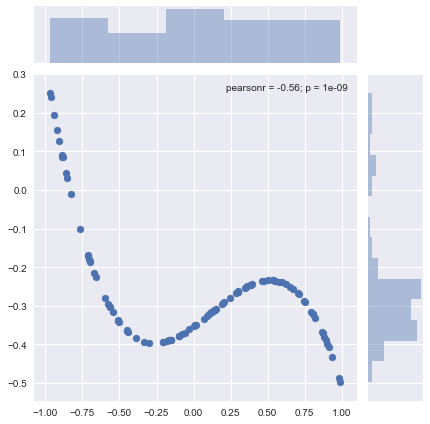

In [21]:
# without noise
sns.jointplot(X, y)

## Intuitively what happens

Before we show how these two noises act in a similar way let's explain what happens when a model tries to fit a noisy model without enough data points.

* Stochastic noise: what will often happen is that the model will 'fit the noise'. Without enough data points the model will confuse outliers with signal and compensate.
* Deterministic noise: what will happen here is that the model will get too few points to see the full complex pattern. Thus it will see other patterns in the data and instead fit to them.

Intuitively both problems lead to overfitting/high variance/low generalization.

But let's go ahead and show this problem experimentally.

Let's consider two targets:

* A 10th order target with noise (stochastic noise example)
* A 40th order target (deterministic noise example)

And two hypothesis sets:

* A second order fit (simple)
* A tenth order fit (complex)

Let's check out the results:

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

# ten data points
X_train = np.random.uniform(-1, 1, size=20)
X_test = np.random.uniform(-1, 1, size=1000)

order_10_L = Legendre(np.random.uniform(-1, 1, size=11))
order_40_L = Legendre(np.random.uniform(-1, 1, size=41))
ys = [
    (order_10_L(X_train),
     order_10_L(X_test)),
    (order_10_L(X_train) + np.random.normal(scale=.1, size=20),
     order_10_L(X_test) + np.random.normal(scale=.1, size=1000)),
    (order_40_L(X_train),
     order_40_L(X_test))]

In [77]:
noises = []
for y_train, y_test in ys:    
    train_errors = []
    test_errors = []
    for features in [2, 10]:
        reg = LinearRegression(fit_intercept=False)
        poly = PolynomialFeatures(features)
        X_train_tran = poly.fit_transform(X_train[:, None])
        X_test_tran = poly.fit_transform(X_test[:, None])

        reg.fit(X_train_tran, y_train)
        
        preds = reg.predict(X_train_tran)
        train_errors.append(mean_squared_error(preds, y_train))
        preds = reg.predict(X_test_tran)
        test_errors.append(mean_squared_error(preds, y_test))
        
    noises.append((train_errors, test_errors))
        

In [78]:
print 'No Noise'
print '############', '2nd Order', '|', '10th Order'
print 'Train Error:', noises[0][0]
print 'Test Error:', noises[0][1]

No Noise
############ 2nd Order | 10th Order
Train Error: [0.073572257338258146, 6.438967746045668e-28]
Test Error: [0.16244589977519855, 3.7180017579156869e-27]


In [79]:
print 'Stochastic Noise'
print '############', '2nd Order', '|', '10th Order'
print 'Train Error:', noises[1][0]
print 'Test Error:', noises[1][1]

Stochastic Noise
############ 2nd Order | 10th Order
Train Error: [0.058502240188570455, 0.0018897357418917293]
Test Error: [0.16231698335610342, 0.75590403119130645]


In [80]:
print 'Deterministic Noise'
print '############', '2nd Order', '|', '10th Order'
print 'Train Error:', noises[2][0]
print 'Test Error:', noises[2][1]

Deterministic Noise
############ 2nd Order | 10th Order
Train Error: [0.19345222619788663, 0.055868493335470323]
Test Error: [0.36141878583001541, 130.81725767448455]


## Empirically what happens 

I should really do the above a couple of times so that you can see the average error here, but I wanted to show you these phenomena, it should be something magical!

What you should pay attention to is the different between the train error and the test error in the above situations. 

First let's look at the no noise case. In the no noise case the target function is simple and there is no added noise. And we can see that the generalization gap is small between both the simpler and the more complex hypothesis. In this low noise case variance has not been able to kick in and the more complex hypothesis is better than the simple one even through there are few data points.

Second we will look at the stochastic noise case. In this case we are looking at the same function that was in the first example, but we add just a little bit of noise (something like 10%). Both hypotheses do worse, but the more complex hypothesis does much worse. Variance was able to kick in and the test error is now greater than the simpler hypothesis. Even though the target function is 10th order, a 2nd order hypothesis set does better. 

Thirdly we will take a look at the deterministic noise. Remember, this is not really random noise here. The idea is that the target funciton grew more complex. The magic here is that the same effect happens. Again the generalization gap is much larger in the 10th order hypothesis set and the test error is worse.

So now you should know the answer to the two questions:

* Why do complex models have higher variance?
* Why do complex models have higher generalization error?

Ultimately the reason is that it fits to the noise. 

## Putting it all together

The final exercise that we will do this time is seeing how deterministic and stochastic noise change with the number of data points. 

We will this time only look at the difference between the 2nd order fit and the 10th order fit:

In [70]:
test_errors = []
for num_data_points in range(20, 150, 5):
    test_error = []
    for target_complexity in range(3, 40, 1):
        error = 0
        for _ in range(10):
            X_train = np.random.uniform(-1, 1, size=num_data_points)
            X_test = np.random.uniform(-1, 1, size=1000)
            
            L = Legendre(np.random.uniform(-1, 1, size=target_complexity))

            y_train = L(X_train)
            y_test = L(X_test)


            reg = LinearRegression(fit_intercept=False)
            poly = PolynomialFeatures(10)
            X_train_tran = poly.fit_transform(X_train[:, None])
            X_test_tran = poly.fit_transform(X_test[:, None])

            reg.fit(X_train_tran, y_train)

            preds = reg.predict(X_test_tran)
            error_10 = mean_squared_error(preds, y_test)

            reg = LinearRegression(fit_intercept=False)
            poly = PolynomialFeatures(2)
            X_train_tran = poly.fit_transform(X_train[:, None])
            X_test_tran = poly.fit_transform(X_test[:, None])

            reg.fit(X_train_tran, y_train)

            preds = reg.predict(X_test_tran)
            error_10 -= mean_squared_error(preds, y_test)
            error += error_10

        test_error.append(error/10)
        
    test_errors.append(test_error)
        

        

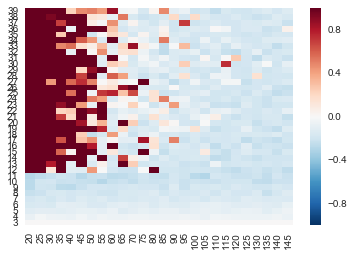

In [72]:
sns.heatmap(np.flipud(np.array(test_errors).T), 
            vmin=-1, vmax=1, 
            xticklabels=range(20, 150, 5),
            yticklabels=range(3, 40, 1)[::-1])

First let me clarify, blue areas are those that the larger hypothesis set does better. They are areas that don't overfit. Red areas are those that the more complex hypothesis did worse. Thus overfit. I have gone ahead and capped the numbers to be between 1 and -1. 

One thing that you should notice is that we see the classic approx-gen/bias-variance trend that we would expect for target functions above 20th order. The less data, the more overfitting. Now below the 20th order line you will notice that it is almost all blue. This means there is no overfitting. Why? Well this is because there is no noise according to the more complex hypothesis. All the target functions are less complex that the hypothesis set and there is no stochastic noise. 

Yep there is that golden trend!

Finally let's try the same thing with stochastic noise. Can you guess what we will see?

In [89]:
test_errors = []
for num_data_points in range(10, 100, 5):
    test_error = []
    for noise_level in range(0, 200, 10):
        error = 0
        for _ in range(10):
            X_train = np.random.uniform(-1, 1, size=num_data_points)
            X_test = np.random.uniform(-1, 1, size=1000)
            
            L = Legendre(np.random.uniform(-1, 1, size=10))

            y_train = L(X_train) + np.random.normal(scale=noise_level/1000., size=num_data_points)
            y_test = L(X_test) + np.random.normal(scale=noise_level/1000., size=1000)


            reg = LinearRegression(fit_intercept=False)
            poly = PolynomialFeatures(10)
            X_train_tran = poly.fit_transform(X_train[:, None])
            X_test_tran = poly.fit_transform(X_test[:, None])

            reg.fit(X_train_tran, y_train)

            preds = reg.predict(X_test_tran)
            error_10 = mean_squared_error(preds, y_test)

            reg = LinearRegression(fit_intercept=False)
            poly = PolynomialFeatures(2)
            X_train_tran = poly.fit_transform(X_train[:, None])
            X_test_tran = poly.fit_transform(X_test[:, None])

            reg.fit(X_train_tran, y_train)

            preds = reg.predict(X_test_tran)
            error_10 -= mean_squared_error(preds, y_test)
            error += error_10

        test_error.append(error/10)
        
    test_errors.append(test_error)        

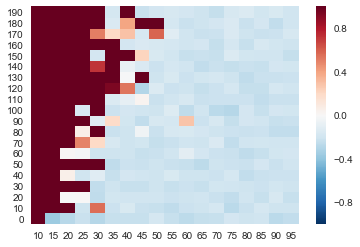

In [91]:
sns.heatmap(np.flipud(np.array(test_errors).T),
            vmin=-1, vmax=1,
            xticklabels=range(10, 100, 5),
            yticklabels=range(0, 200, 10)[::-1])

Again we notice our beautiful trend. As the noise increases, we overfit more. As the data points increase we overfit less. There is one important thing to note here. It we have a noiseless model (bottom row) we get abosulutely no overfitting.

## Conclusion

Hopefully by now you have seen this trend to the point that you are convinced and intuitively grasp what is happening. More complex models will overfit to noise without enough data. You can measure the extent of this overfit with the bias variance framework or the approximation generalization framework.

This result is the most important result in machine learning.

In the next two lessons, we will talk about how to overcome this problem with regularization and cross validaiton.

## Learning Objectives

Today we learn the answer to these two questions:

* Why do complex models have higher variance?
* Why do complex models have higher generalization error?

The answer will be noise!

## Comprehension Questions

1.	Why do complex models have higher variance?
2.	Why do complex models have higher generalization error?
3.	What is deterministic noise? Can you describe it to a non-technical person?
4.	Which noise is worse: stochastic or deterministic?
5.	What does fitting to the noise mean? Do people sometimes fit to the noise?
6.	With enough data, does noise matter?
